In [53]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

In [54]:
class Arm:
    def __init__(self, p, q):
        self.p = p
        self.q = q
        self.success = 0
        self.proxy_success = 0
        self.fail = 0

    def play(self):
        proxy = random.binomial(n=1, p=self.p)
        result = proxy * random.binomial(n=1, p=self.q)
        return proxy, result

    def update(self, proxy, result):
        if result == 1:
            self.success += 1
        elif proxy == 1:
            self.proxy_success += 1
        else:
            self.fail += 1

In [55]:
def thompson_sampling(arms, T, alpha1=1, beta1=1):
    optimal_value = max(arm.p * arm.q for arm in arms)
    regret_history = []
    regret = 0

    for _ in range(T):
        samples = [random.beta(arm.success+alpha1, arm.proxy_success+arm.fail+beta1) for arm in arms]
        max_arm = np.argmax(samples)
        proxy, result = arms[max_arm].play()

        regret += (optimal_value - arms[max_arm].p * arms[max_arm].q)
        regret_history.append(regret)

        arms[max_arm].update(proxy, result)

    return regret_history

def thompson_sampling_with_proxy(arms, T, alpha1=1, beta1=1, alpha2=1, beta2=1):
    optimal_value = max(arm.p * arm.q for arm in arms)
    regret_history = []
    regret = 0

    for _ in range(T):
        samples = [random.beta(arm.success+arm.proxy_success+alpha1, arm.fail+beta1) * random.beta(arm.success+alpha2, arm.proxy_success+beta2) for arm in arms]
        max_arm = np.argmax(samples)
        proxy, result = arms[max_arm].play()

        regret += optimal_value - arms[max_arm].p * arms[max_arm].q
        regret_history.append(regret)

        arms[max_arm].update(proxy, result)

    return regret_history

def regret_lower_bound(arms, T):
    optimal_value = max(arm.p * arm.q for arm in arms)

    coef = 0
    for arm in arms:
        if arm.p * arm.q == optimal_value:
            continue
        difference = optimal_value - arm.p * arm.q
        kl = arm.p * arm.q * np.log(arm.p * arm.q / optimal_value) + (1 - arm.p * arm.q) * np.log((1 - arm.p * arm.q) / (1 - optimal_value))
        coef += difference / kl

    time_steps = np.arange(1, T+1)
    log_regret = coef * np.log(time_steps)

    return  log_regret

In [ ]:
T = 100000
N = 100

random.seed(42)

pq_values_fixed = [
    [0.9, 0.8],
    [0.7, 0.6],
    [0.5, 0.4],
    [0.2, 0.1],
]

def calculate_regret(algorithm, *args):
    regret_histories = []
    for _ in range(N):
        arms = [Arm(p, q) for p, q in pq_values_fixed]
        regret_history = algorithm(arms, T, *args)
        regret_histories.append(regret_history)

    mean_regret = np.mean(regret_histories, axis=0)
    regret_5 = np.percentile(regret_histories, 5, axis=0)
    regret_95 = np.percentile(regret_histories, 95, axis=0)

    return mean_regret, regret_5, regret_95

mean_regret, regret_5, regret_95 = calculate_regret(thompson_sampling_with_proxy, 1, 1, 1, 1)
lb_mean, _, _ = calculate_regret(regret_lower_bound)
time_steps = np.arange(1, T+1)
marker_indices = np.logspace(0, np.log10(T-1), num=20, dtype=int)

plt.figure(figsize=(8, 8))
plt.plot(time_steps, lb_mean, linestyle=':', marker='s', markevery=marker_indices, label='Lower Bound')
plt.plot(time_steps, mean_regret, linestyle='-', marker='o', markevery=marker_indices, label='Thompson Sampling with Proxy')
plt.fill_between(time_steps, regret_5, regret_95, alpha=0.2, color='orange', zorder=0)
plt.xlabel('Time', fontsize=30)
plt.ylabel('Regret', fontsize=30)
plt.legend(fontsize=18)
plt.grid(True)
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
plt.savefig('data/output1.png')


In [ ]:
T = 10000
N = 100

random.seed(42)

def calculate_regret(algorithm, *args):
    regret_histories = []
    for _ in range(N):
        pq_values = [[random.uniform(0, 1), random.uniform(0, 1)] for _ in range(4)]
        arms = [Arm(p, q) for p, q in pq_values]
        regret_history = algorithm(arms, T, *args)
        regret_histories.append(regret_history)

    mean_regret = np.mean(regret_histories, axis=0)

    return mean_regret

ts_mean_regret = calculate_regret(thompson_sampling, 1, 3)
ts_proxy_mean_regret = calculate_regret(thompson_sampling_with_proxy, 1, 1, 1, 1)
lb_mean = calculate_regret(regret_lower_bound)
time_steps = np.arange(1, T+1)


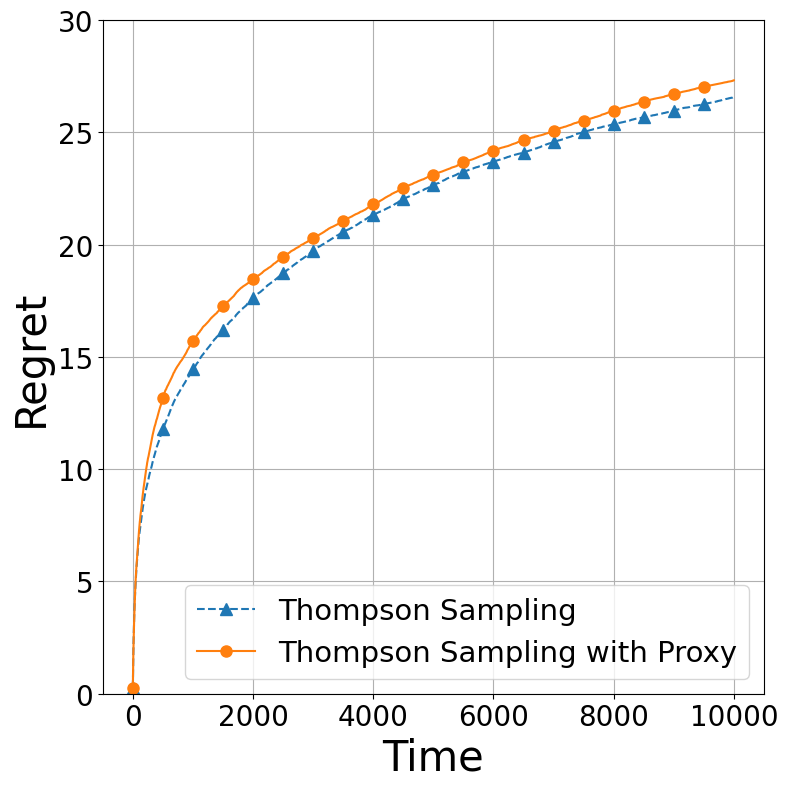

In [ ]:
marker_indices = 500
plt.figure(figsize=(8, 8))
plt.plot(time_steps, ts_mean_regret, linestyle='--', marker='^', markevery=marker_indices, markersize=8, label='Thompson Sampling')
plt.plot(time_steps, ts_proxy_mean_regret, linestyle='-', marker='o', markevery=marker_indices, markersize=8, label='Thompson Sampling with Proxy')
plt.xlabel('Time', fontsize=30)
plt.ylabel('Regret', fontsize=30)
plt.ylim(0,30)
plt.legend(fontsize=21)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
plt.savefig('data/output2-a-1.png')

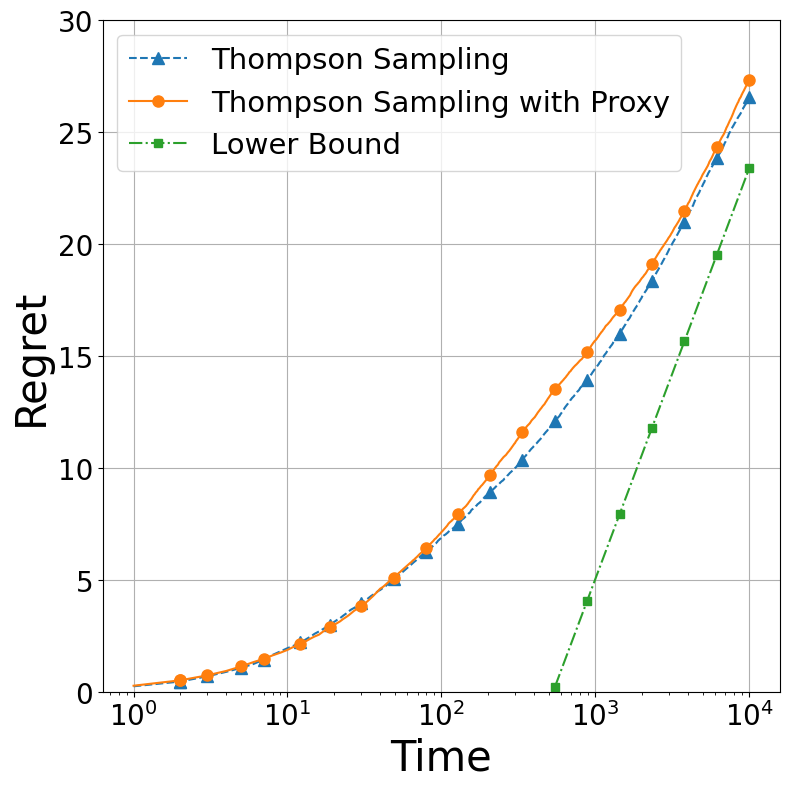

In [ ]:
marker_indices = np.logspace(0, np.log10(T-1), num=20, dtype=int)
plt.figure(figsize=(8, 8))
plt.plot(time_steps, ts_mean_regret, linestyle='--', marker='^', markevery=marker_indices, markersize=8, label='Thompson Sampling')
plt.plot(time_steps, ts_proxy_mean_regret, linestyle='-', marker='o', markevery=marker_indices, markersize=8, label='Thompson Sampling with Proxy')
plt.plot(time_steps, lb_mean-50, linestyle='-.', marker='s', markevery=marker_indices, label='Lower Bound')
plt.xscale('log')
plt.xlabel('Time', fontsize=30)
plt.ylabel('Regret', fontsize=30)
plt.ylim(0,30)
plt.legend(fontsize=21)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
plt.savefig('data/output2-a-2.png')

In [ ]:
T = 10000
N = 100

np.random.seed(42)

def calculate_regret(algorithm, *args):
    regret_histories = []
    for _ in range(N):
        pq_values = [[np.random.uniform(0.01, 0.1), np.random.uniform(0.01, 0.1)] for _ in range(4)]
        arms = [Arm(p, q) for p, q in pq_values]
        regret_history = algorithm(arms, T, *args)
        regret_histories.append(regret_history)

    mean_regret = np.mean(regret_histories, axis=0)

    return mean_regret

ts_mean_regret_1 = calculate_regret(thompson_sampling, 1, 399)
ts_mean_regret_2 = calculate_regret(thompson_sampling, 2, 798)
ts_mean_regret_3 = calculate_regret(thompson_sampling, 3, 1197)
ts_proxy_mean_regret_1 = calculate_regret(thompson_sampling_with_proxy, 1, 19, 1, 19)
ts_proxy_mean_regret_2 = calculate_regret(thompson_sampling_with_proxy, 2, 28, 2, 28)
ts_proxy_mean_regret_3 = calculate_regret(thompson_sampling_with_proxy, 3, 57, 3, 57)
lb_mean = calculate_regret(regret_lower_bound)
time_steps = np.arange(1, T+1)

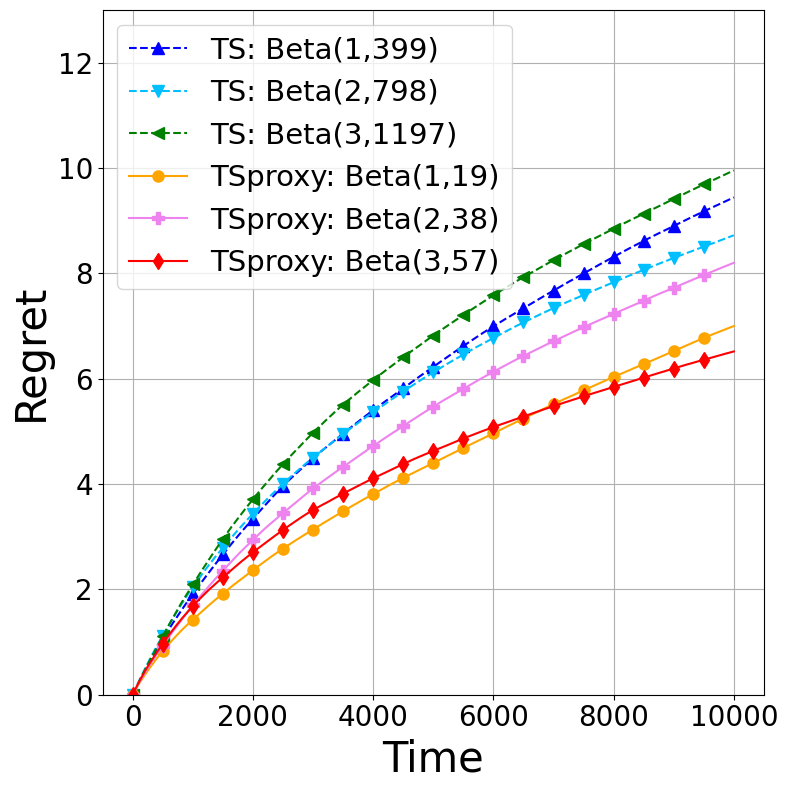

In [ ]:
marker_indices = 500
plt.figure(figsize=(8, 8))
plt.plot(time_steps, ts_mean_regret_1, linestyle='--', marker='^', markevery=marker_indices, markersize=8, color='blue', label='TS: Beta(1,399)')
plt.plot(time_steps, ts_mean_regret_2, linestyle='--', marker='v', markevery=marker_indices, markersize=8, color='deepskyblue', label='TS: Beta(2,798)')
plt.plot(time_steps, ts_mean_regret_3, linestyle='--', marker='<', markevery=marker_indices, markersize=8, color='green', label='TS: Beta(3,1197)')
plt.plot(time_steps, ts_proxy_mean_regret_1, linestyle='-', marker='o', markevery=marker_indices, markersize=8, color='orange', label='TSproxy: Beta(1,19)')
plt.plot(time_steps, ts_proxy_mean_regret_2, linestyle='-', marker='P', markevery=marker_indices, markersize=8, color='violet', label='TSproxy: Beta(2,38)')
plt.plot(time_steps, ts_proxy_mean_regret_3, linestyle='-', marker='d', markevery=marker_indices, markersize=8, color='red', label='TSproxy: Beta(3,57)')
plt.xlabel('Time', fontsize=30)
plt.ylabel('Regret', fontsize=30)
plt.ylim(0,13)
plt.legend(fontsize=21)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
plt.savefig('data/output2-b-1.png')

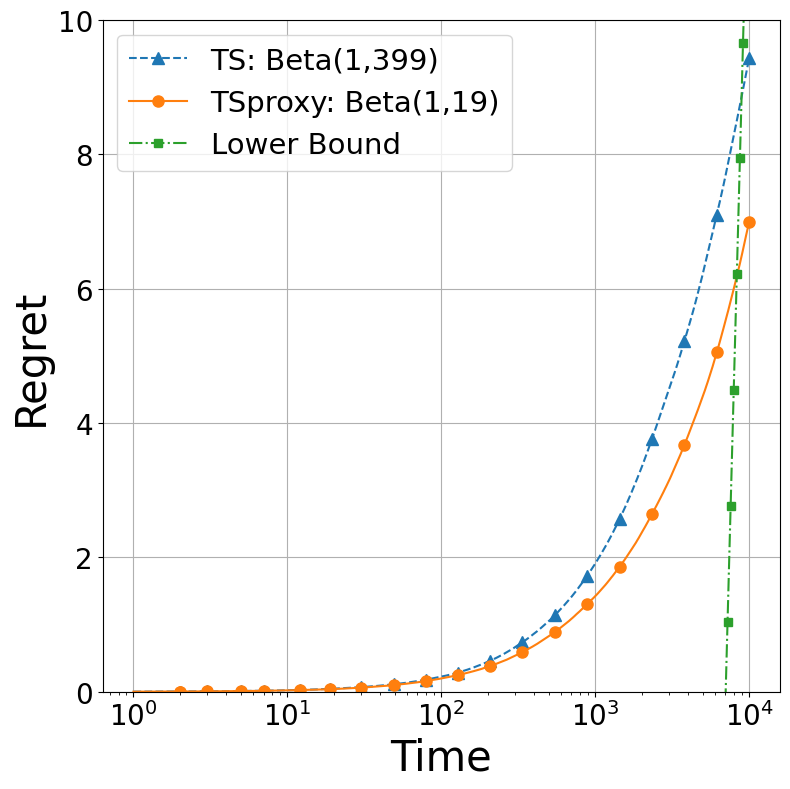

In [ ]:
marker_indices = np.logspace(0, np.log10(len(time_steps)-1), num=20, dtype=int)
plt.figure(figsize=(8, 8))
plt.plot(time_steps, ts_mean_regret_1, linestyle='--', marker='^', markevery=marker_indices, markersize=8, label='TS: Beta(1,399)')
plt.plot(time_steps, ts_proxy_mean_regret_1, linestyle='-', marker='o', markevery=marker_indices, markersize=8, label='TSproxy: Beta(1,19)')
marker_indices = np.logspace(0, np.log10(len(time_steps)-1), num=200, dtype=int)
plt.plot(time_steps, lb_mean-330, linestyle='-.', marker='s', markevery=marker_indices, label='Lower Bound')
plt.xscale('log')
plt.xlabel('Time', fontsize=30)
plt.ylabel('Regret', fontsize=30)
plt.ylim(0,10)
plt.legend(fontsize=21)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
plt.savefig('data/output2-b-2.png')

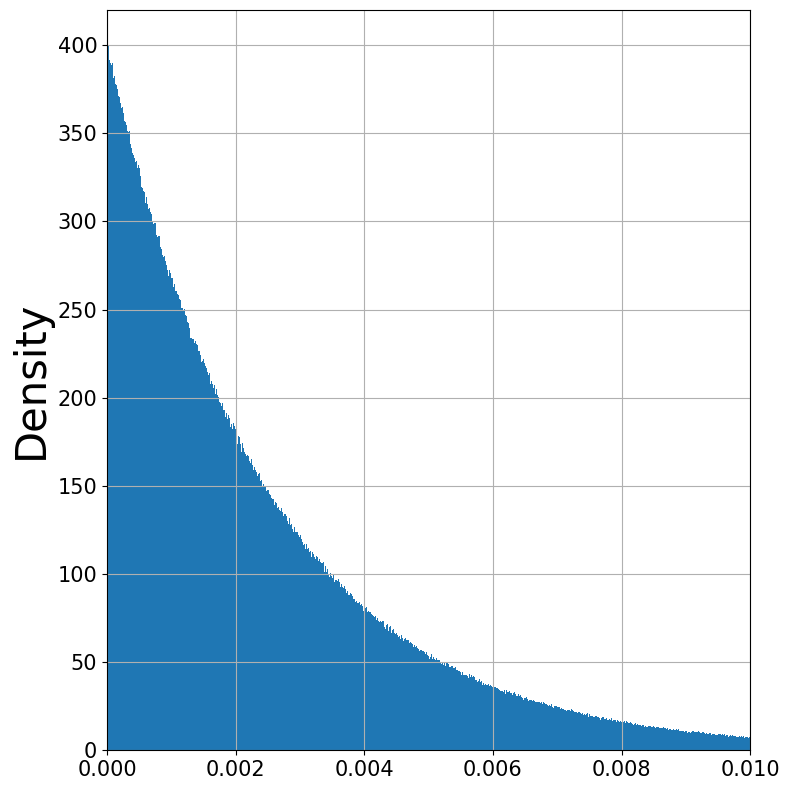

In [ ]:
arm = Arm(0.1, 0.1)

a, b = 1, 399
samples = random.beta(arm.success+a, arm.proxy_success+arm.fail+b, size=10000000)

plt.figure(figsize=(8, 8))
plt.hist(samples, bins=5000, density=True)
plt.ylabel('Density', fontsize=30)
plt.xlim(0, 0.01)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.savefig('data/output3-a-1.png')

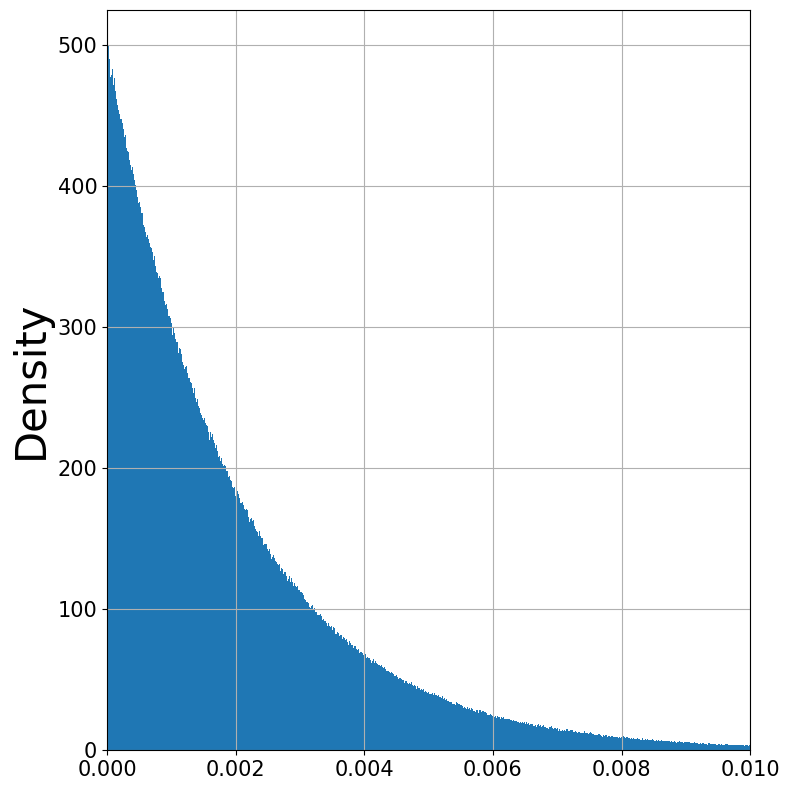

In [ ]:
T = 100
arm = Arm(0.1, 0.1)

random.seed(42)
for _ in range(T):
    proxy, result = arm.play()
    arm.update(proxy, result)

a, b = 1, 399
samples = random.beta(arm.success+a, arm.proxy_success+arm.fail+b, size=10000000)

plt.figure(figsize=(8, 8))
plt.hist(samples, bins=5000, density=True)
plt.ylabel('Density', fontsize=30)
plt.xlim(0, 0.01)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.savefig('data/output3-a-2.png')

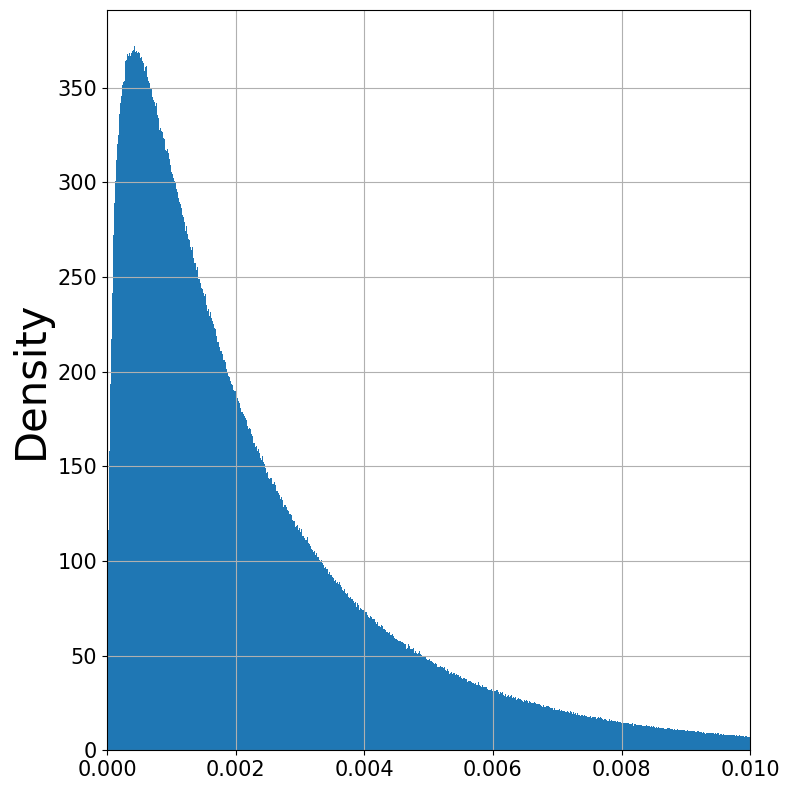

In [ ]:
arm = Arm(0.1, 0.1)

a, b = 2, 38
samples = random.beta(arm.success+arm.proxy_success+a, arm.fail+b, size=10000000) * random.beta(arm.success+a, arm.proxy_success+b, size=10000000)

plt.figure(figsize=(8, 8))
plt.hist(samples, bins=5000, density=True)
plt.ylabel('Density', fontsize=30)
plt.xlim(0, 0.01)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.savefig('data/output3-b-1.png')

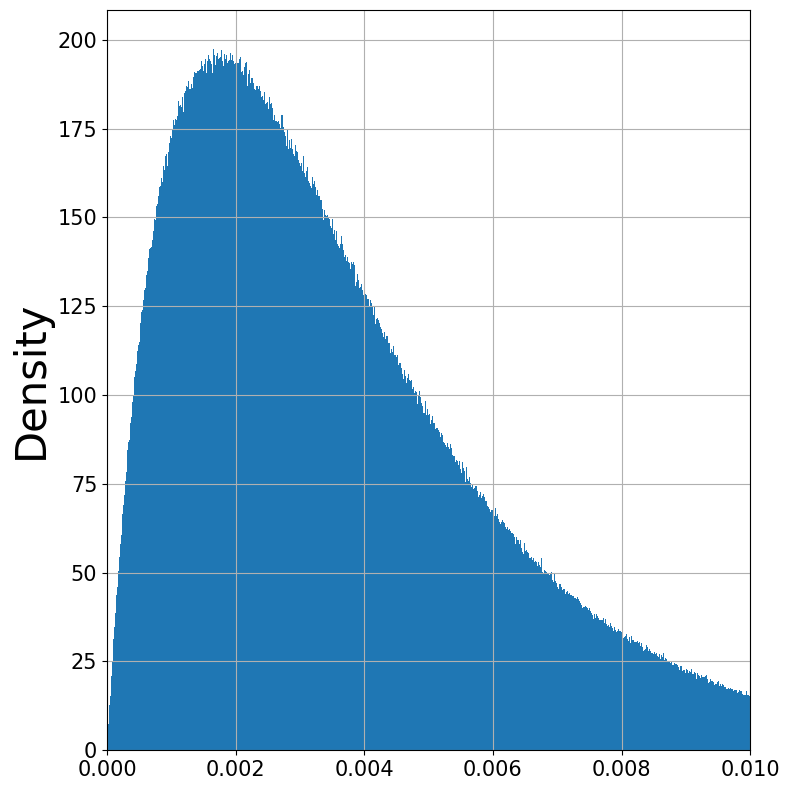

In [ ]:
T = 100
arm = Arm(0.1, 0.1)

random.seed(42)
for _ in range(T):
    proxy, result = arm.play()
    arm.update(proxy, result)

a, b = 2, 38
samples = random.beta(arm.success+arm.proxy_success+a, arm.fail+b, size=10000000) * random.beta(arm.success+a, arm.proxy_success+b, size=10000000)

plt.figure(figsize=(8, 8))
plt.hist(samples, bins=5000, density=True)
plt.ylabel('Density', fontsize=30)
plt.xlim(0, 0.01)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.savefig('data/output3-b-2.png')